In [11]:
import os, sys, time, resource, re, gc, shutil
import operator
from multiprocess import Pool
from functools import partial
from urllib.parse import urlparse, parse_qsl
from django.db.models import Count
import matplotlib


mp_pdf = False
if mp_pdf:
    extension = "pdf"
    import matplotlib
    matplotlib.use('pgf')
    pgf_with_latex = {
        "text.usetex": True,            # use LaTeX to write all text
        "pgf.rcfonts": False,           # Ignore Matplotlibrc
        "text.latex.unicode": True,
        "pgf.preamble": [
            #r"\usepackage[utf8x]{inputenc}",
            r"\usepackage{xcolor}"
        ],
        "pgf.texsystem" : "xelatex",
        "figure.figsize": [12,7]
    }
    matplotlib.rcParams.update(pgf_with_latex)
else:
    extension = "png"

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import django
from adjustText import adjust_text

sys.path.append('/home/galm/software/django/tmv/BasicBrowser/')
os.environ.setdefault("DJANGO_SETTINGS_MODULE", "BasicBrowser.settings")
django.setup()

from scoping.models import *
from tmv_app.models import *
from django.db.models import F, Sum, Count
from matplotlib import gridspec

from utils.utils import *

from run_id import run_id

run_id = 1861

runstat = RunStats.objects.get(pk=run_id)
topics = DynamicTopic.objects.filter(run_id=run_id)

docs = Doc.objects.filter(
    query=runstat.query,
    content__iregex="\w"
)



In [2]:
years = list(range(1990,2015))
years

s_solutions = []
ip_solutions = []

r = "(?:\W|^)policy"

for y in years:
    ydocs = docs.filter(PY=y)
    sdocs = ydocs.filter(content__iregex=r)
    s_count = sdocs.count()
    s_solutions.append(s_count/ydocs.count())
    ip_docs = ydocs.filter(ipccref__isnull=False)
    ip_solution_docs = ip_docs.filter(content__iregex=r)
    try:
        ip_solutions.append(ip_solution_docs.count()/ip_docs.count())
    except:
        ip_solutions.append(0)
    #ipdocs = ydocs.filter()
    

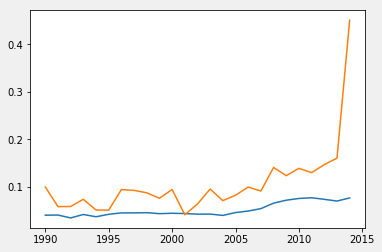

In [3]:
fig = plt.figure()

plt.plot(years,s_solutions)
plt.plot(years, ip_solutions)

fig.patch.set_facecolor('#f0f0f0')    
#plt.tight_layout()

plt.savefig(
    f'../plots/solutions.{extension}',
    bbox_inches='tight',
    facecolor=fig.get_facecolor(),
)
plt.show()

In [4]:
if runstat.method=="DT":
    dts = DocTopic.objects.filter(
        run_id=run_id,
        doc__PY__lt=2014,
        score__gt=runstat.dt_threshold,
        topic__topicdtopic__dynamictopic__run_id=run_id,
        topic__topicdtopic__score__gt=runstat.dt_threshold
    ).values('topic__topicdtopic__dynamictopic__id')

    dts = dts.annotate(
        solution = models.Sum(
            models.Case(
                models.When(
                    doc__content__iregex=r,
                    then=F('score')*F('topic__topicdtopic__score')
                ),
                default=0,
                output_field=models.FloatField()
            )
        )
    )

    df = pd.DataFrame.from_dict(list(dts.values(
        'topic__topicdtopic__dynamictopic__title',
        'solution',
        'topic__topicdtopic__dynamictopic__score'
    ))).rename(columns={
        'topic__topicdtopic__dynamictopic__title':'topic__title',
        'topic__topicdtopic__dynamictopic__score': 'score'
    })
else:
    dts = DocTopic.objects.filter(
        run_id=run_id,
        doc__PY__lt=2014,
        score__gt=runstat.dt_threshold,
    ).values('topic__title')

    dts = dts.annotate(
        solution = models.Sum(
            models.Case(
                models.When(
                    doc__content__iregex=r,
                    then=F('score')
                ),
                default=0,
                output_field=models.FloatField()
            )
        )
    )

    df = pd.DataFrame.from_dict(list(dts.values(
        'topic__title',
        'solution',
        'score'
    )))
    
df.head()
                                     
                                    


,score,solution,topic__title
0,0.004901,0.0,"absorption, absorption (of CO2 for capture)"
1,0.004902,0.0,"absorption, absorption (of CO2 for capture)"
2,0.004903,0.0,"absorption, absorption (of CO2 for capture)"
3,0.004904,0.0,"absorption, absorption (of CO2 for capture)"
4,0.004904,0.0,"absorption, absorption (of CO2 for capture)"


In [5]:
topics = Topic.objects.filter(
    run_id=run_id,
    #primary_wg=3
).values('doctopic__doc__wc__oecd').annotate(
    dis_share = Sum('doctopic__score')
).order_by('id','doctopic__doc__wc__oecd')

topic_dis_df = pd.DataFrame.from_dict(list(topics.values(
    'title','doctopic__doc__wc__oecd','dis_share','primary_wg'
)))

print(topic_dis_df.shape)

topic_dis_df.head()

(980, 4)


,dis_share,doctopic__doc__wc__oecd,primary_wg,title
0,98.609781,Agricultural Sciences,2,"indices, indices, correlation and relationships"
1,185.606297,Engineering and Technology,2,"indices, indices, correlation and relationships"
2,2.184284,Humanities,2,"indices, indices, correlation and relationships"
3,13.903700,Medical and Health Sciences,2,"indices, indices, correlation and relationships"
4,655.278080,Natural Sciences,2,"indices, indices, correlation and relationships"


In [6]:
topics = Topic.objects.filter(
    run_id=run_id,
    #primary_wg=3
).filter(
    doctopic__doc__PY__lt=2014
).values('doctopic__doc__wc__oecd').annotate(
    dis_share_pre = Sum('doctopic__score')
).order_by('id','doctopic__doc__wc__oecd')

topic_dis_df_pre = pd.DataFrame.from_dict(list(topics.values(
    'title','doctopic__doc__wc__oecd','dis_share_pre','primary_wg'
)))

topics = Topic.objects.filter(
    run_id=run_id,
    #primary_wg=3
).filter(
    doctopic__doc__PY__gte=2014
).values('doctopic__doc__wc__oecd').annotate(
    dis_share_post = Sum('doctopic__score')
).order_by('id','doctopic__doc__wc__oecd')

topic_dis_df_post = pd.DataFrame.from_dict(list(topics.values(
    'title','doctopic__doc__wc__oecd','dis_share_post','primary_wg'
)))



In [7]:
new_df = pd.merge(topic_dis_df, topic_dis_df_pre)
new_df = pd.merge(new_df,topic_dis_df_post)
new_df.head()

,dis_share,doctopic__doc__wc__oecd,primary_wg,title,dis_share_pre,dis_share_post
0,98.609781,Agricultural Sciences,2,"indices, indices, correlation and relationships",45.168047,53.441733
1,185.606297,Engineering and Technology,2,"indices, indices, correlation and relationships",73.102808,112.503490
2,2.184284,Humanities,2,"indices, indices, correlation and relationships",0.756985,1.427299
3,13.903700,Medical and Health Sciences,2,"indices, indices, correlation and relationships",5.620609,8.283041
4,655.278080,Natural Sciences,2,"indices, indices, correlation and relationships",310.473621,344.804458


In [8]:
topic_dis_wide = topic_dis_df.pivot_table(
    index=["title","primary_wg"],columns="doctopic__doc__wc__oecd",values="dis_share"
).reset_index()
topic_dis_wide.head()

doctopic__doc__wc__oecd,title,primary_wg,Agricultural Sciences,Engineering and Technology,Humanities,Medical and Health Sciences,Natural Sciences,Social Sciences
0,"(e)-vehicles, electric, hybrid and combustion ...",3,3.907608,130.339487,0.556164,1.427391,56.675816,35.375804
1,"CH4, CH4",1,42.279069,34.275047,0.043176,0.646459,127.684489,1.363110
2,"CLC, chemical looping combustion (CLC)",1,16.887115,243.378720,0.595492,2.226257,202.564765,8.282349
3,"CO2 storage, geological CO2 storage",3,16.643268,168.666964,0.564576,1.527617,151.085227,9.202484
4,"CO2, CO2",1,45.375992,196.184304,0.391513,1.549563,284.346652,10.687394


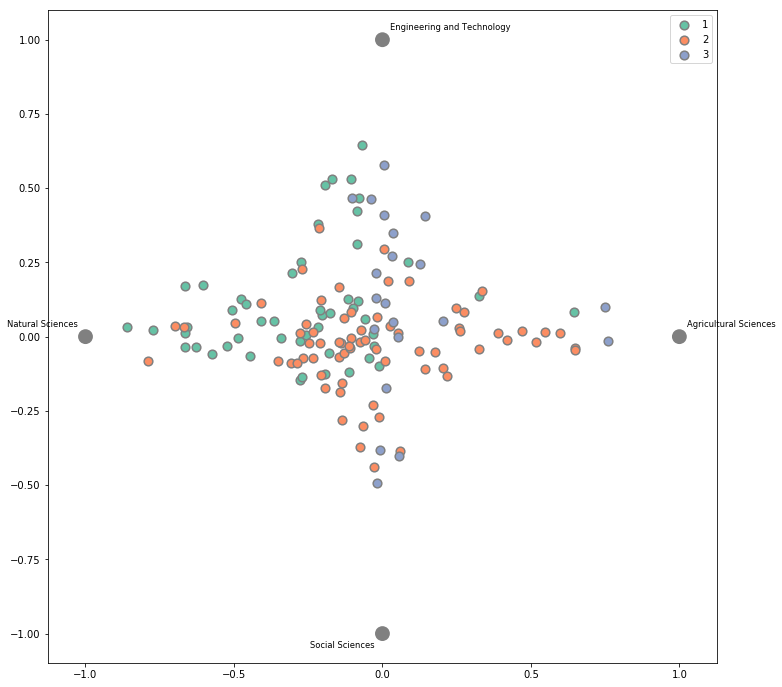

In [9]:

fig, ax = plt.subplots(figsize=(12,12))

cols = [
    "primary_wg",
    "Agricultural Sciences", 
    "Engineering and Technology",
    "Natural Sciences", 
    "Social Sciences"
]

rad_viz = pd.plotting.radviz(
    topic_dis_wide[cols].sort_values('primary_wg'), 
    'primary_wg', 
    ax=ax,
    color=["#66c2a5","#fc8d62","#8da0cb"],
    edgecolors="grey",
    linewidths=1.5,
    s = 75
) 

plt.show()

In [10]:
new_df.to_csv(f'../tables/topic_discipline_{run_id}.csv',index=False)